In [1]:
from matplotlib import pyplot as plt
from streaming.client import RemoteCamera
from skimage import io
import numpy as np
import cv2

from super_gradients.training import models
from super_gradients.common.object_names import Models

[2023-05-13 20:43:16] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /Users/pierreadorni/sg_logs/console.log


[2023-05-13 20:43:17] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-05-13 20:43:18] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-13 20:43:18] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-13 20:43:18] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-13 20:43:18] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-05-13 20:43:18] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


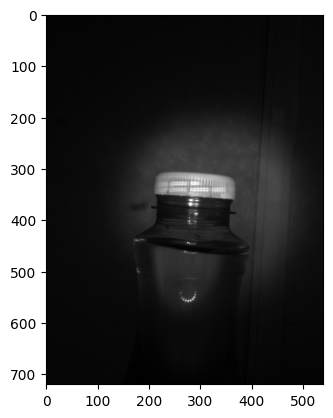

In [19]:
testimg = io.imread('0006.jpg')
plt.imshow(testimg, cmap='gray')

In [2]:
net = models.get(Models.YOLO_NAS_S, pretrained_weights="coco")

[2023-05-13 20:43:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [30]:
# image grayscale to hwc
testimg = np.repeat(testimg[:, :, np.newaxis], 3, axis=2)
results = [r for r in net.predict([testimg], conf=0.7)][0]

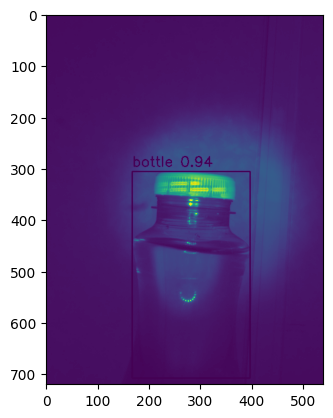

In [62]:
class_names = results.class_names
labels = results.prediction.labels.astype(int)
confidence = results.prediction.confidence
bboxes = results.prediction.bboxes_xyxy

for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
    print(f"Found {class_names[label]} with confidence {conf} at {bbox}")
    # draw the bounding box
    x1, y1, x2, y2 = bbox.astype(int)
    cv2.rectangle(testimg, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # draw the label
    cv2.putText(testimg, f"{class_names[label]} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

plt.imshow(testimg)

In [65]:
subimg = testimg[y1:y2, x1:x2]

In [33]:
# segment subimage with SAM
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
sam = sam_model_registry["vit_b"](checkpoint="../models/sam_vit_b.pth")
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [34]:
predictor.set_image(subimg)

In [35]:
input_point = np.array([
    [10, subimg.shape[1]/2],
    [subimg.shape[0]/2, subimg.shape[1]/2],
    [subimg.shape[0]-10, subimg.shape[1]/2],
    [10, 10],
    [10, subimg.shape[1]-10],
])
input_label = np.array([1, 0, 0, 0, 0])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

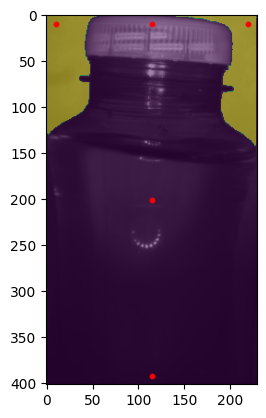

In [36]:
# show original image with a point at input_point
plt.imshow(subimg)
plt.scatter(input_point[:, 1], input_point[:, 0], c='r', s=10)
# show mask
plt.imshow(masks[0], alpha=0.5)

Les résultats sont mauvais: SAM n'arrive pas à détourer le bouchon.

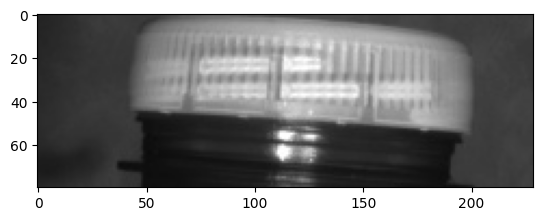

In [37]:
# crop out the cap (1/6 of the image)
cap = subimg[:subimg.shape[0]//5, :]
plt.imshow(cap)

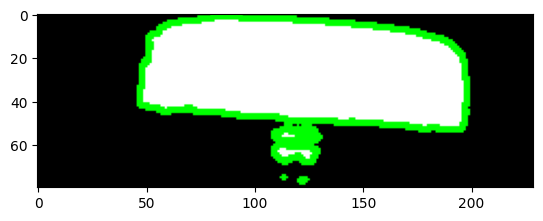

In [38]:
# compute the horizontal derivative to detect edges
cap = cv2.cvtColor(cap, cv2.COLOR_RGB2GRAY)
cap = cv2.Sobel(cap, cv2.CV_64F, 1, 0, ksize=5)
cap = cv2.convertScaleAbs(cap)
plt.imshow(cap, cmap='gray')

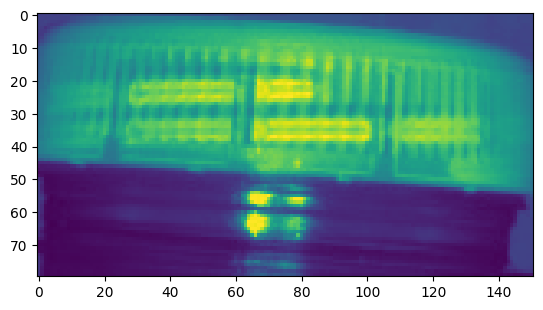

In [66]:
# threshold the image
_, cap = cv2.threshold(cap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(cap, cmap='gray')

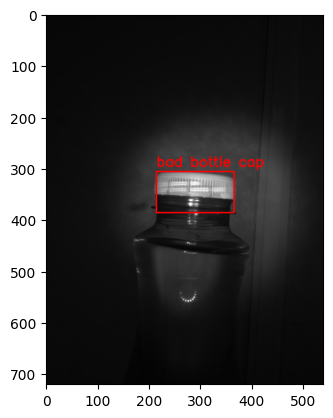

In [77]:
# find contours and draw them
contours, _ = cv2.findContours(cap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cap = cv2.cvtColor(cap, cv2.COLOR_GRAY2RGB)
cv2.drawContours(cap, contours, -1, (0, 255, 0), 2)
plt.imshow(cap)

In [7]:
from typing import Tuple, Optional


# put the entire process in a function
def find_bottle_cap(image: np.ndarray) -> Optional[Tuple[int,int,int,int]]:
    """
    Estimates the position of the bottle cap in an image, using Yolo and Sobel.
    """
    # detect whole bottle with yolo
    results = [r for r in net.predict([image], conf=0.7)][0]
    class_names = results.class_names
    labels = results.prediction.labels.astype(int)
    confidence = results.prediction.confidence
    bboxes = results.prediction.bboxes_xyxy


    # find the bbox that corresponds to the "bottle" class
    x1, y1, x2, y2 = 0, 0, 0, 0
    for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
        if class_names[label] == "bottle":
            x1, y1, x2, y2 = bbox.astype(int)
            break

    # if no bottle is found, return None
    if x1 == 0 and y1 == 0 and x2 == 0 and y2 == 0:
        return None

    # crop out the cap (1/5 of the image)
    cap = image[y1:y1+(y2-y1)//5, x1:x2, :]

    # find contours using cv2.findContours ( cap is in HWC format )
    cap = cv2.cvtColor(cap, cv2.COLOR_RGB2GRAY)
    _, cap = cv2.threshold(cap, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(cap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # crop horizontally the cap by finding the leftmost and rightmost contours x coordinates
    x_left = np.min([np.min(contour[:, 0, 0]) for contour in contours])
    x_right = np.max([np.max(contour[:, 0, 0]) for contour in contours])

    # return the coordinates of the cap in the original image
    return x_left + x1, y1, x_right + x1, y1 + (y2-y1)//5

In [21]:
# grayscale to hwc
testimg = np.repeat(testimg[:, :, np.newaxis], 3, axis=2)

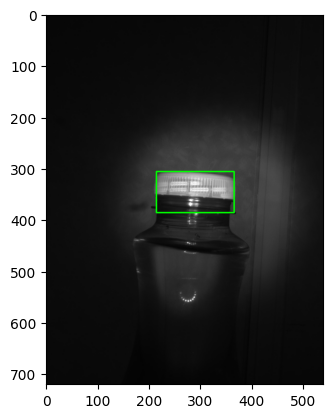

In [31]:
x1, y1, x2, y2 = find_bottle_cap(testimg)
testimg_w_cap = testimg.copy()
cv2.rectangle(testimg_w_cap, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(testimg_w_cap)

In [8]:
def show_bottle_cap_of_image(filename: str) -> None:
    image = io.imread(filename)
    # grayscale to hwc
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    bbox = find_bottle_cap(image)
    if bbox is None:
        print(f"no bottle cap found in {filename}")
        return
    x1, y1, x2, y2 = bbox
    image_w_cap = image.copy()
    cv2.rectangle(image_w_cap, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(image_w_cap)

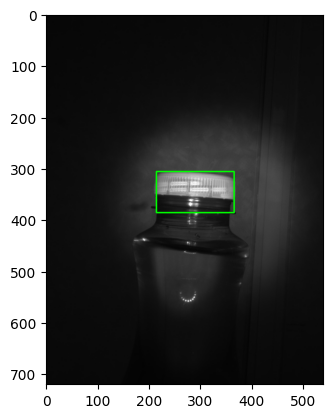

In [14]:
show_bottle_cap_of_image("../dataset/neg/0005.jpg")